<a href="https://colab.research.google.com/github/ashivashankars/CMPE256_Assignments/blob/main/Hopping_Window_Crude_Oil_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Hopping Window - Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma

In [3]:
import pandas as pd

# ----------------------------
# 1) Load data
#    Expect a CSV with columns: DATE, DCOILWTICO
#    If you're pulling from FRED or elsewhere, just make sure the two columns exist.
# ----------------------------
df = pd.read_csv("DCOILWTICO.csv")  # change path/filename as needed
df["DATE"] = pd.to_datetime(df["DATE"])
# Convert the 'DCOILWTICO' column to numeric, coercing errors
df["DCOILWTICO"] = pd.to_numeric(df["DCOILWTICO"], errors='coerce')
df = df.sort_values("DATE").set_index("DATE")

# Optional: ensure a true daily index (FRED often has missing weekends/holidays).
# We forward-fill so the rolling window is on calendar days. If you prefer to
# compute only over trading days, comment these two lines out.
df = df.asfreq("D")
df["DCOILWTICO"] = df["DCOILWTICO"].ffill()

# ----------------------------
# 2) Hopping window parameters
#    - window_size: length of each window (7 days for "weekly" window)
#    - hop: how often you want an output point (weekly cadence here)
#      Use 'W-MON' to label weeks ending on Mondays, or pick 'W-FRI'/'W-SUN', etc.
# ----------------------------
window_size = "7D"
hop = "W-MON"   # weekly hop; change to '1D' for daily hop (full rolling series)

# ----------------------------
# 3) Compute hopping-window stats on a daily grid
#    Rolling with a time-based window gives overlapping (hopping) windows.
#    We compute it daily, then sample at the desired hop cadence.
# ----------------------------
s = df["DCOILWTICO"]

# Rolling window over the last 7 calendar days ending at each date (inclusive)
weekly_mean_daily = s.rolling(window=window_size, min_periods=1).mean()
weekly_max_daily  = s.rolling(window=window_size, min_periods=1).max()

# ----------------------------
# 4) Downsample to the hop cadence (weekly labels)
#    `.resample(hop).last()` picks the value at the last timestamp within each hop bin,
#    which corresponds to the 7-day window ending at that week's label.
# ----------------------------
out = pd.DataFrame({
    "weekly_window_mean": weekly_mean_daily,
    "weekly_window_max":  weekly_max_daily
}).resample(hop).last().dropna()

# (Optional) Add the window start/end for clarity
out = out.assign(
    window_end = out.index,
    window_start = out.index - pd.to_timedelta(window_size) + pd.Timedelta(days=0)  # inclusive start
)[["window_start", "window_end", "weekly_window_mean", "weekly_window_max"]]

# ----------------------------
# 5) Done: 'out' now contains one row per hop (weekly),
#    where each value is computed over the last 7 calendar days (hopping window).
# ----------------------------
print(out.head(10))

# ----------------------------
# Variants / Tips:
# ----------------------------
# • If you want a DAILY hopping window series (hop = 1 day), just set:
#       hop = "1D"
#   and keep everything else the same. You’ll get a value for every day.
#
# • If you prefer weeks ending on Sundays, set:
#       hop = "W-SUN"
#
# • If you DON’T want to forward-fill non-trading days, remove the asfreq/ffill
#   step and compute rolling directly on the business-day index. You’ll still get
#   a 7D time-based window, but it will span fewer observations over holidays/weekends.
#
# • If you want a strict “7 observations” window instead of 7 calendar days,
#   use: s.rolling(window=7, min_periods=1) instead of the time-based '7D'.

           window_start window_end  weekly_window_mean  weekly_window_max
DATE                                                                     
2019-10-28   2019-10-21 2019-10-28           55.600000              55.60
2019-11-04   2019-10-28 2019-11-04           55.522857              56.33
2019-11-11   2019-11-04 2019-11-11           56.882857              57.04
2019-11-18   2019-11-11 2019-11-18           57.080000              57.54
2019-11-25   2019-11-18 2019-11-25           57.261429              58.36
2019-12-02   2019-11-25 2019-12-02           57.831429              58.25
2019-12-09   2019-12-02 2019-12-09           58.517143              59.20
2019-12-16   2019-12-09 2019-12-16           59.668571              60.21
2019-12-23   2019-12-16 2019-12-23           60.701429              61.30
2019-12-30   2019-12-23 2019-12-30           61.571429              61.76


In [4]:
# The previous cell already calculated the weekly mean and max using the hopping window strategy.
# The results are stored in the 'out' DataFrame.
# Display the 'out' DataFrame which contains the weekly mean and max.
display(out)

,window_start,window_end,weekly_window_mean,weekly_window_max
DATE,,,,
2019-10-28,2019-10-21,2019-10-28,55.600000,55.60
2019-11-04,2019-10-28,2019-11-04,55.522857,56.33
2019-11-11,2019-11-04,2019-11-11,56.882857,57.04
2019-11-18,2019-11-11,2019-11-18,57.080000,57.54
2019-11-25,2019-11-18,2019-11-25,57.261429,58.36
...,...,...,...,...
2024-09-30,2024-09-23,2024-09-30,69.421429,72.34
2024-10-07,2024-09-30,2024-10-07,74.004286,77.76
2024-10-14,2024-10-07,2024-10-14,75.572857,76.46


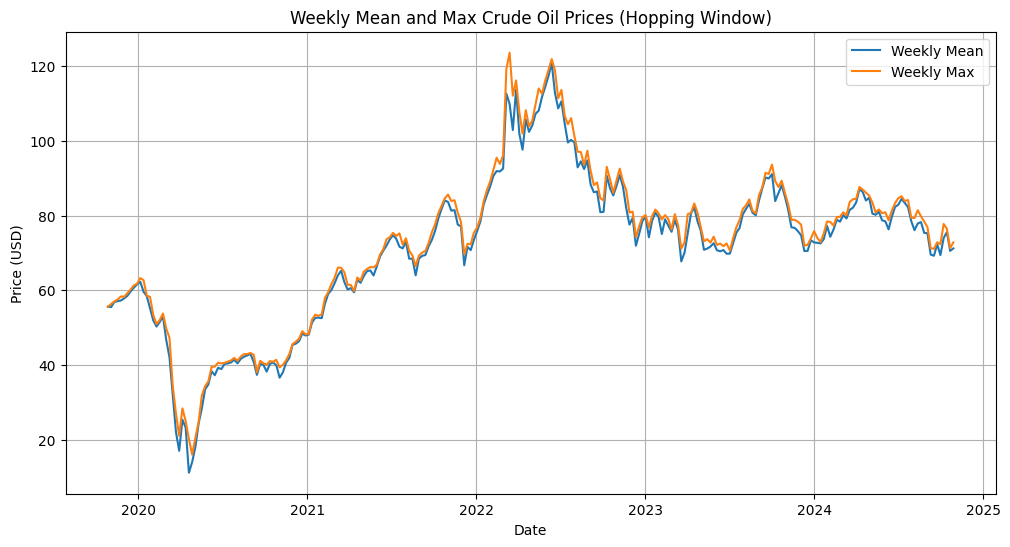

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(out.index, out['weekly_window_mean'], label='Weekly Mean')
plt.plot(out.index, out['weekly_window_max'], label='Weekly Max')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Weekly Mean and Max Crude Oil Prices (Hopping Window)')
plt.legend()
plt.grid(True)
plt.show()